In [404]:
! pip install seaborn==0.12.2

In [405]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

def random_acc(R, NR):
    positive_samples = R
    negative_samples = NR
    total_samples = positive_samples + negative_samples
    
    # For random guessing, the probability of guessing a sample correctly is:
    # (probability of guessing a positive correctly + probability of guessing a negative correctly) / total possibilities
    
    # The probability of guessing a positive sample correctly is the proportion of positive samples,
    # and similarly for negative samples.
    
    random_guess_accuracy = (positive_samples/total_samples * positive_samples/total_samples) + \
                            (negative_samples/total_samples * negative_samples/total_samples)
    return random_guess_accuracy

import math
import colorcet as cc
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, ax, ncols=4, sort_colors=True, anote = False, margin = 12, swatch_width = 30):

    cell_width = 230
    cell_height = 30
    swatch_width = swatch_width
    margin = margin

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    #fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    # ax.subplots_adjust(margin/width, margin/height,
    #                     (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

        if anote:
            ax.text(swatch_start_x, y, colors[name], #fontsize=10,
                    horizontalalignment='left', color = 'white',
                    verticalalignment='center')

    return ax

In [406]:
df_c2c = pd.read_csv('./stratification/cancer2cancer.csv', index_col=0)
df_d2d = pd.read_csv('./stratification/drug2drug.csv', index_col=0)
df_s2s = pd.read_csv('./stratification/sequencer2sequencer.csv', index_col=0)

df_label = pd.concat([df_c2c, df_d2d, df_s2s])
cohorts = df_label['stratified_cohort'].unique().tolist()

In [407]:
from glob import glob

In [408]:
csvs = glob('./*_run/F2F/*/metric_performance.tsv')

In [409]:
res = []
for csv in csvs:
    df = pd.read_csv(csv, sep='\t', index_col=0)
    res.append(df)

In [410]:
def change_name(x):
    x,y,z = x.split('_')
    return '(%s,%s)%s' % (x,y,z)
    
df = pd.concat(res)
#df['transfer'] = df.train_cohort.apply(lambda x:change_name(x)) + '$\mapsto$' + df.test_cohort.apply(lambda x:change_name(x))
df['transfer'] = df.train_cohort + '$\mapsto$' + df.test_cohort

smodes = [ 'LFT', 'PFT', 'FFT', 'NFT', 
          'NetBio', 'GEP', 'MIAS', 'NRS', 'IMPRES', 'PGM',  'TIDE', 'TAM', 'Texh', 'CAF',
          'PD1','PDL1','CTLA4', ] #'GeneBio'

#df = df[df['mode'].isin(smodes)]

In [411]:
#df.reset_index().train_cohort.apply(lambda x:x.split('_')).apply(lambda x:len(x)).sort_values()

In [412]:
#df.reset_index().iloc[790]

In [413]:
df['mode'].unique()

array(['CAF', 'CD8', 'CIS', 'CKS', 'CTL', 'CTLA4', 'GEP', 'GeneBio',
       'ICA', 'IFNG', 'IMPRES', 'IS', 'MIAS', 'NRS', 'NetBio', 'PD1',
       'PDL1', 'PGM', 'TAM', 'TIDE', 'Teff', 'Texh', 'FFT', 'LFT', 'NFT',
       'PFT'], dtype=object)

In [414]:
df['mode'].unique()

array(['CAF', 'CD8', 'CIS', 'CKS', 'CTL', 'CTLA4', 'GEP', 'GeneBio',
       'ICA', 'IFNG', 'IMPRES', 'IS', 'MIAS', 'NRS', 'NetBio', 'PD1',
       'PDL1', 'PGM', 'TAM', 'TIDE', 'Teff', 'Texh', 'FFT', 'LFT', 'NFT',
       'PFT'], dtype=object)

In [415]:
#'CIS', 'CKS', 'CTL', 'ICA','IS',

In [416]:
cancer_domain = ['Atezo_HiSeq2500_BLCA',
  'Atezo_HiSeq2500_KIRC',
  'Nivo_HiSeq2000_GBM',
  'Nivo_HiSeq2000_KIRC',
  'Nivo_HiSeq2500_LUAD',
  'Nivo_HiSeq2500_SKCM',
  'Pembro_HiSeq2500_LUAD',
  'Pembro_HiSeq2500_SKCM',
  'Pembro_HiSeq2500_STAD']

drug_domain = ['BLCA_NovaSeq6000_Atezo',
  'BLCA_NovaSeq6000_Pembro',
  'LUAD_HiSeq2500_Nivo',
  'LUAD_HiSeq2500_Pembro',
  'SKCM_HiSeq2500_Ipi',
  'SKCM_HiSeq2500_Nivo',
  'SKCM_HiSeq2500_Pembro']

sequencer_domain =['BLCA_Atezo_HiSeq2500',
  'BLCA_Atezo_HiSeq4000',
  'BLCA_Atezo_NovaSeq6000',
  'SKCM_Nivo_HiSeq2000/2500',
  'SKCM_Nivo_HiSeq2500',
  'SKCM_Pembro_HiSeq2000',
  'SKCM_Pembro_HiSeq2500']

In [417]:
train_cohorts = drug_domain 
test_cohorts = drug_domain

## Merge & analysis

In [418]:
data = df.reset_index(drop=True)
data.head()

,domain,group,train_cohort,test_cohort,mode,best_C,test_cohort_rgc,ROC,PRC,F1,ACC,MCC,best_epoch,transfer
0,cancer2cancer,"(Atezo,HiSeq2500)","(Atezo,HiSeq2500)BLCA","(Atezo,HiSeq2500)KIRC",CAF,0.1,0.587438,0.581375,0.333563,0.455285,0.593939,0.165667,NaN,"(Atezo,HiSeq2500)BLCA$\mapsto$(Atezo,HiSeq2500..."
1,cancer2cancer,"(Atezo,HiSeq2500)","(Atezo,HiSeq2500)KIRC","(Atezo,HiSeq2500)BLCA",CAF,0.1,0.647764,0.551854,0.244666,0.388626,0.567114,0.133950,NaN,"(Atezo,HiSeq2500)KIRC$\mapsto$(Atezo,HiSeq2500..."
2,cancer2cancer,"(Nivo,HiSeq2000)","(Nivo,HiSeq2000)GBM","(Nivo,HiSeq2000)KIRC",CAF,0.1,0.755102,0.648148,0.448347,0.333333,0.619048,0.196419,NaN,"(Nivo,HiSeq2000)GBM$\mapsto$(Nivo,HiSeq2000)KIRC"
3,cancer2cancer,"(Nivo,HiSeq2000)","(Nivo,HiSeq2000)KIRC","(Nivo,HiSeq2000)GBM",CAF,0.1,0.580000,0.559524,0.431157,0.428571,0.600000,0.133631,NaN,"(Nivo,HiSeq2000)KIRC$\mapsto$(Nivo,HiSeq2000)GBM"
4,cancer2cancer,"(Nivo,HiSeq2500)","(Nivo,HiSeq2500)LUAD","(Nivo,HiSeq2500)SKCM",CAF,0.1,0.524691,0.327561,0.330770,0.352941,0.388889,-0.203859,NaN,"(Nivo,HiSeq2500)LUAD$\mapsto$(Nivo,HiSeq2500)SKCM"


In [419]:
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()
ot = '#cccccc'

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3],

            # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
            # 'Teff':f4[8], 'GeneBio':f4[9],
            
            'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
            'Teff':ot, 'GeneBio':ot,
            
            'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
            'PD1':ot,  'NetBio':ot, 
            'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot,
            }

In [420]:
sns.palettes.color_palette('rainbow', 7, desat = 1)


[(0.24901960784313715, 0.3841057491719256, 0.9806347704689778),
 (0.0019607843137254832, 0.7092813076058532, 0.9232891061054892),
 (0.2529411764705882, 0.9256376597815561, 0.8301840308155508),
 (0.5039215686274509, 0.999981027348727, 0.7049255469061473),
 (0.7549019607843138, 0.9209055179449537, 0.5523649729605058),
 (1.0, 0.7005430375932911, 0.37841105004231035),
 (1.0, 0.37270199199091436, 0.18980109344182594)]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:1.913e-03 U_stat=5.080e+02
drug2drug vs. cancer2cancer: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.385e+02
drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.958e-04 U_stat=5.320e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:1.561e-01 U_stat=4.160e+02
drug2drug vs. cancer2cancer: Mann-Whitney-Wilcoxon test two-sided, P_val:2.002e-01 U_stat=4.085e+02
drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:8.948e-04 U

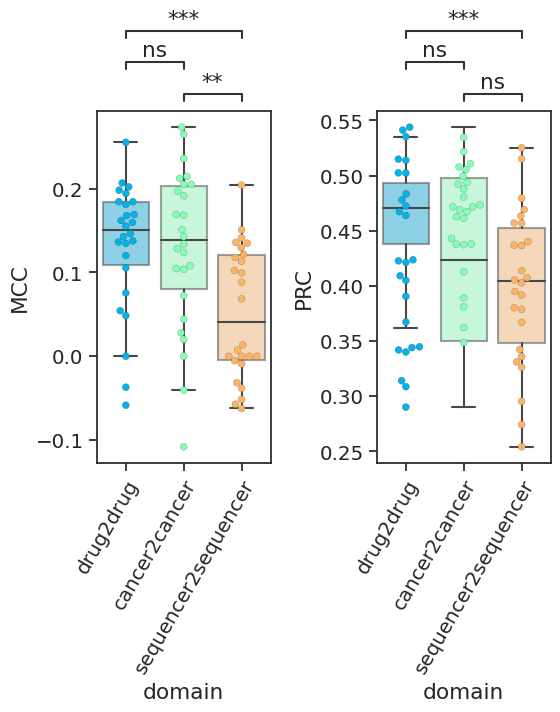

In [421]:
import scipy
from statannotations.Annotator import Annotator
fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), ncols=2, sharex=False, sharey=False)

box_pairs = [('sequencer2sequencer', 'drug2drug'),
             ('cancer2cancer', 'sequencer2sequencer'), 
             ('cancer2cancer', 'drug2drug')]

dfd = data.groupby(['domain', 'mode']).MCC.median().unstack().T
x_order = dfd.mean(axis=0).sort_values(ascending=False).index.tolist()
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain',  order = x_order, y = 0,   ax=ax1,  fliersize=0, palette='rainbow',  
            boxprops={'alpha':0.5})
sns.swarmplot(datap, x='domain', y = 0,   ax=ax1, palette='rainbow', linewidth = 0.2, order=x_order)

annotator = Annotator(ax1, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

ax1.set_ylabel('MCC')
ax1.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax1.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke


#====================================================================================
dfd = data.groupby(['domain', 'mode'])['PRC'].median().unstack().T
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain', y = 0,  order = x_order,  ax=ax2,  fliersize=0, palette='rainbow',  
            boxprops={'alpha':0.5})
sns.swarmplot(datap, x='domain', y = 0,   ax=ax2, palette='rainbow', linewidth = 0.2)

annotator = Annotator(ax2, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


ax2.set_ylabel('PRC')
ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax2.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke

fig.tight_layout()
fig.savefig('./domain_transfer_comparasions.pdf', bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:1.913e-03 U_stat=5.080e+02
drug2drug vs. cancer2cancer: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.385e+02
drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.958e-04 U_stat=5.320e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cancer2cancer vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.948e-01 U_stat=3.850e+02
drug2drug vs. cancer2cancer: Mann-Whitney-Wilcoxon test two-sided, P_val:3.553e-01 U_stat=2.870e+02
drug2drug vs. sequencer2sequencer: Mann-Whitney-Wilcoxon test two-sided, P_val:5.520e-01 U

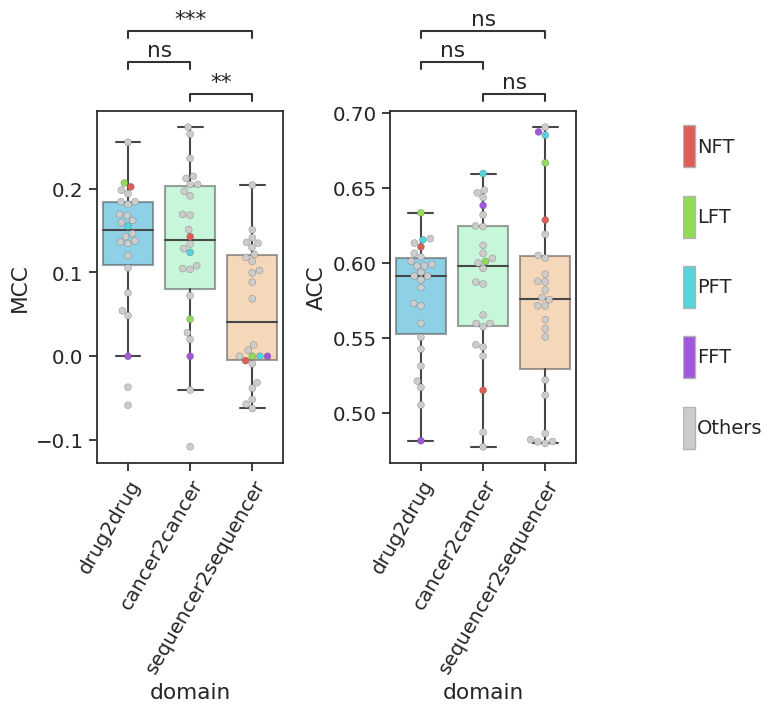

In [422]:
import scipy
from statannotations.Annotator import Annotator
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(8, 8), ncols=3, sharex=False, sharey=False, width_ratios = [1,1,0.3])

box_pairs = [('sequencer2sequencer', 'drug2drug'),
             ('cancer2cancer', 'sequencer2sequencer'), 
             ('cancer2cancer', 'drug2drug')]

dfd = data.groupby(['domain', 'mode'])['MCC'].median().unstack().T
x_order = dfd.mean(axis=0).sort_values(ascending=False).index.tolist()
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain',  order = x_order, y = 0,   ax=ax1,   palette='rainbow',   fliersize=0,
            boxprops={'alpha':0.5})

g = sns.swarmplot(datap, x='domain', y = 0,   ax=ax1, palette=mode_palette, linewidth = 0.2, order=x_order,
             hue = 'mode', hue_order = list(mode_palette.keys())
             )
g.get_legend().set_visible(False)



annotator = Annotator(ax1, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

ax1.set_ylabel('MCC')
ax1.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax1.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke


#====================================================================================
dfd = data.groupby(['domain', 'mode'])['ACC'].median().unstack().T
y_order = dfd.mean(axis=1).sort_values().index
datap = dfd.loc[y_order].T
datap = datap.unstack().reset_index()


sns.boxplot(datap, x='domain', y = 0,  order = x_order,  ax=ax2,  fliersize=0, palette='rainbow',  
            boxprops={'alpha':0.5})
#sns.swarmplot(datap, x='domain', y = 0,   ax=ax2, palette='rainbow', linewidth = 0.2)

g = sns.swarmplot(datap, x='domain', y = 0,   ax=ax2, palette=mode_palette, linewidth = 0.2, order=x_order,
             hue = 'mode', hue_order = list(mode_palette.keys())
             )
g.get_legend().set_visible(False)

annotator = Annotator(ax2, pairs=box_pairs, data=datap, x='domain', y=0, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


ax2.set_ylabel('ACC')
ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

ax2.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke


mode_palette2 = { 'NFT':f4[0], 'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                 'Others': '#cccccc'}

ax3 = plot_colortable(mode_palette2, ax3, sort_colors = False, margin = 1, swatch_width = 50, ncols=1)



fig.tight_layout()
#fig.savefig('./domain_transfer_comparasions.pdf', bbox_inches='tight')

In [423]:
df['mode'].unique()

array(['CAF', 'CD8', 'CIS', 'CKS', 'CTL', 'CTLA4', 'GEP', 'GeneBio',
       'ICA', 'IFNG', 'IMPRES', 'IS', 'MIAS', 'NRS', 'NetBio', 'PD1',
       'PDL1', 'PGM', 'TAM', 'TIDE', 'Teff', 'Texh', 'FFT', 'LFT', 'NFT',
       'PFT'], dtype=object)

In [424]:
colors = sns.color_palette('PiYG', 10)
mt_color = colors[-2]
nt_color = colors[1]
colors

[(0.7514033064206075, 0.09588619761630142, 0.4736639753940792),
 (0.8513648596693579, 0.395924644367551, 0.6446751249519416),
 (0.9231833910034601, 0.6410611303344866, 0.804152249134948),
 (0.9755478662053056, 0.8202998846597462, 0.9081891580161476),
 (0.9792387543252595, 0.9279507881584006, 0.954479046520569),
 (0.938562091503268, 0.9650903498654364, 0.8996539792387543),
 (0.8382929642445216, 0.9331026528258363, 0.7132641291810845),
 (0.6558246828143024, 0.8396770472895041, 0.4459054209919264),
 (0.4595924644367551, 0.7049596309111881, 0.23029603998462128),
 (0.2873510188389081, 0.5548635140330642, 0.1263360246059208)]

In [425]:
data

,domain,group,train_cohort,test_cohort,mode,best_C,test_cohort_rgc,ROC,PRC,F1,ACC,MCC,best_epoch,transfer
0,cancer2cancer,"(Atezo,HiSeq2500)","(Atezo,HiSeq2500)BLCA","(Atezo,HiSeq2500)KIRC",CAF,0.1,0.587438,0.581375,0.333563,0.455285,0.593939,0.165667,NaN,"(Atezo,HiSeq2500)BLCA$\mapsto$(Atezo,HiSeq2500..."
1,cancer2cancer,"(Atezo,HiSeq2500)","(Atezo,HiSeq2500)KIRC","(Atezo,HiSeq2500)BLCA",CAF,0.1,0.647764,0.551854,0.244666,0.388626,0.567114,0.133950,NaN,"(Atezo,HiSeq2500)KIRC$\mapsto$(Atezo,HiSeq2500..."
2,cancer2cancer,"(Nivo,HiSeq2000)","(Nivo,HiSeq2000)GBM","(Nivo,HiSeq2000)KIRC",CAF,0.1,0.755102,0.648148,0.448347,0.333333,0.619048,0.196419,NaN,"(Nivo,HiSeq2000)GBM$\mapsto$(Nivo,HiSeq2000)KIRC"
3,cancer2cancer,"(Nivo,HiSeq2000)","(Nivo,HiSeq2000)KIRC","(Nivo,HiSeq2000)GBM",CAF,0.1,0.580000,0.559524,0.431157,0.428571,0.600000,0.133631,NaN,"(Nivo,HiSeq2000)KIRC$\mapsto$(Nivo,HiSeq2000)GBM"
4,cancer2cancer,"(Nivo,HiSeq2500)","(Nivo,HiSeq2500)LUAD","(Nivo,HiSeq2500)SKCM",CAF,0.1,0.524691,0.327561,0.330770,0.352941,0.388889,-0.203859,NaN,"(Nivo,HiSeq2500)LUAD$\mapsto$(Nivo,HiSeq2500)SKCM"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,sequencer2sequencer,"(BLCA,Atezo)","(BLCA,Atezo)NovaSeq6000","(BLCA,Atezo)HiSeq4000",PFT,NaN,0.555556,0.775510,0.494377,0.000000,0.666667,0.000000,5.0,"(BLCA,Atezo)NovaSeq6000$\mapsto$(BLCA,Atezo)Hi..."
828,sequencer2sequencer,"(SKCM,Nivo)","(SKCM,Nivo)HiSeq2000/2500","(SKCM,Nivo)HiSeq2500",PFT,NaN,0.524691,0.679654,0.669125,0.428571,0.703704,0.370688,9.0,"(SKCM,Nivo)HiSeq2000/2500$\mapsto$(SKCM,Nivo)H..."
829,sequencer2sequencer,"(SKCM,Nivo)","(SKCM,Nivo)HiSeq2500","(SKCM,Nivo)HiSeq2000/2500",PFT,NaN,0.684737,0.665854,0.294587,0.363636,0.450980,0.139686,6.0,"(SKCM,Nivo)HiSeq2500$\mapsto$(SKCM,Nivo)HiSeq2..."
830,sequencer2sequencer,"(SKCM,Pembro)","(SKCM,Pembro)HiSeq2000","(SKCM,Pembro)HiSeq2500",PFT,NaN,0.514486,0.488112,0.390161,0.586466,0.414894,0.000000,5.0,"(SKCM,Pembro)HiSeq2000$\mapsto$(SKCM,Pembro)Hi..."


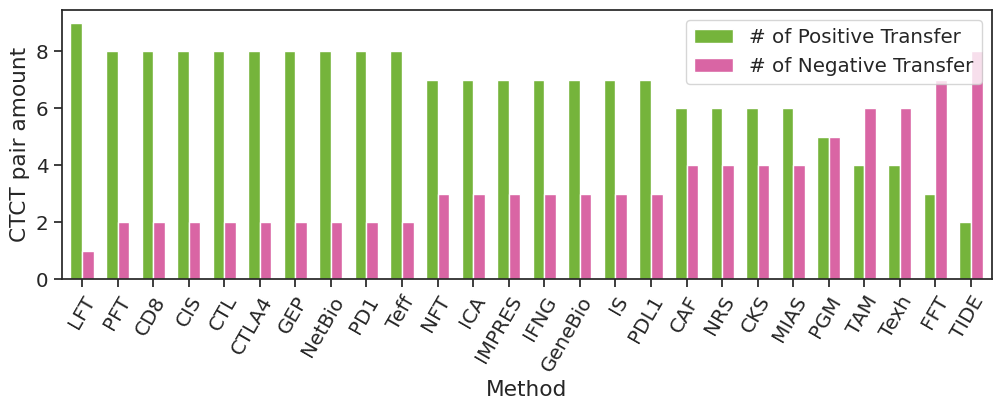

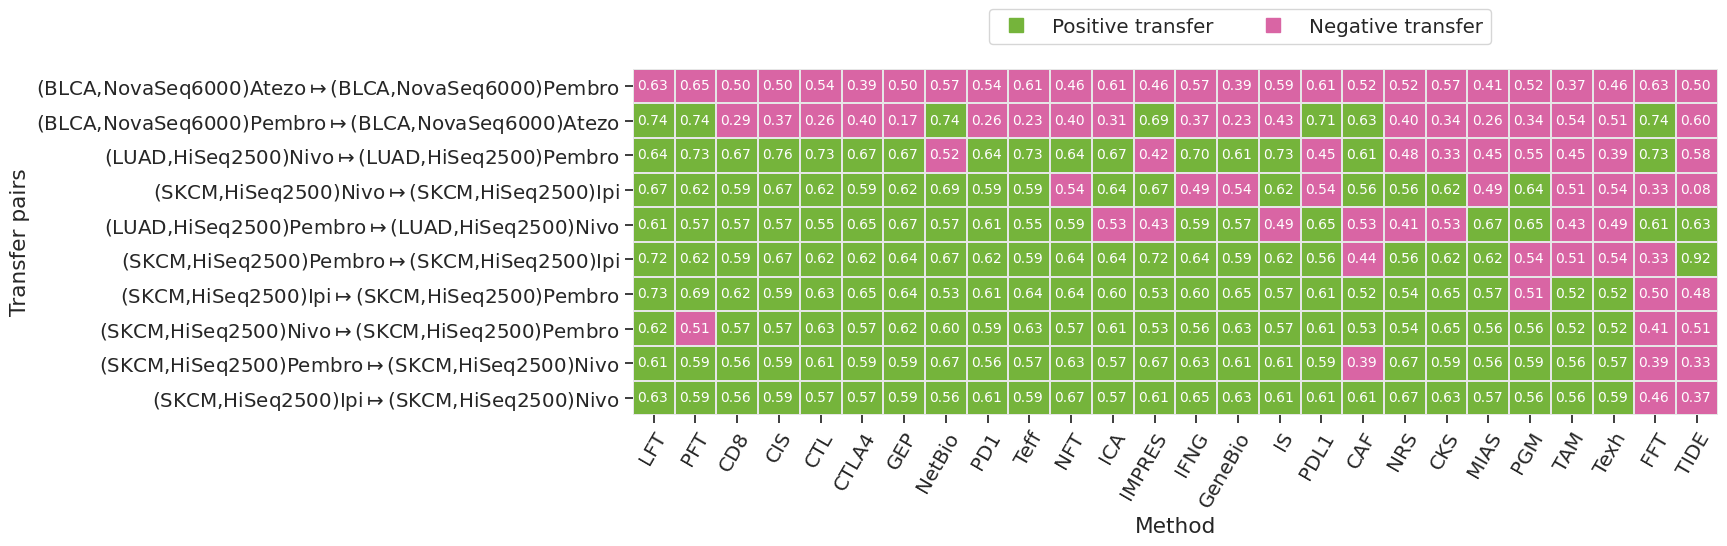

In [426]:
datas = data[data.domain == 'drug2drug'] #[data.train_cohort.isin(drug_domain) & data.test_cohort.isin(drug_domain)]
data_mt = datas[(datas.ACC > datas.test_cohort_rgc) ] #& (datas.MCC > 0)
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc) ] #& (datas.MCC < 0)
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(12, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values().index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./drug2drug_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p
    
y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.ACC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 
fig.savefig('./drug2drug_heatmap.pdf', bbox_inches='tight')
fig.savefig('./drug2drug_heatmap.svg', bbox_inches='tight')

dfd_pos = dfb1.sum()/len(dfb1)
dfd_neg = dfb2.sum()/len(dfb2)
x_order_d = x_order

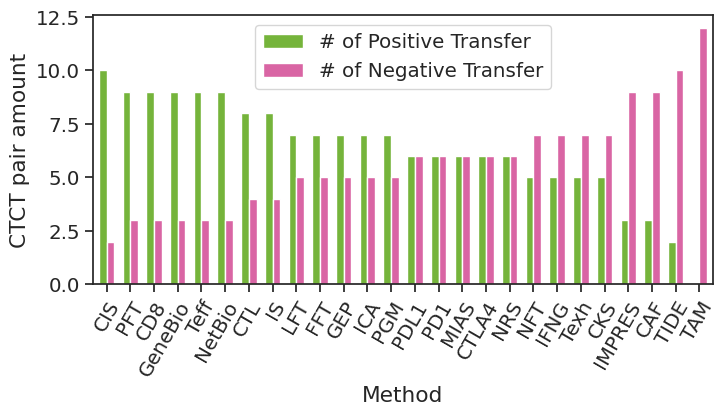

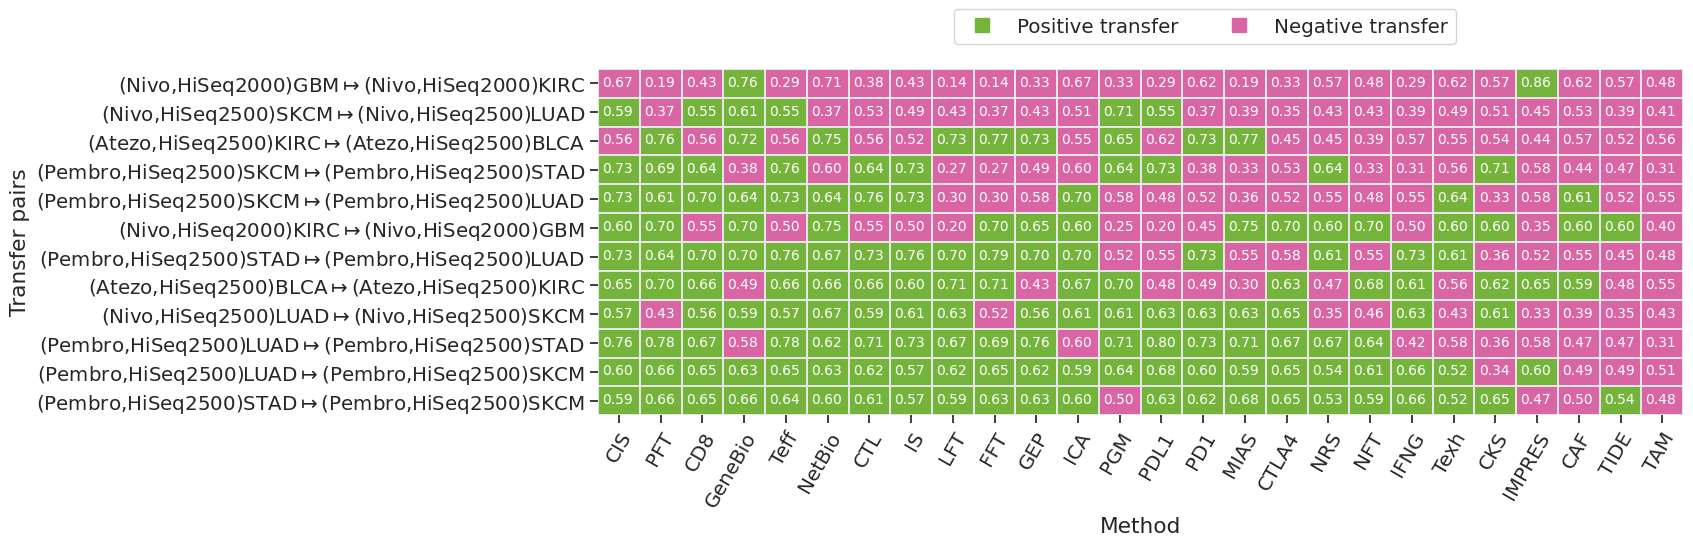

In [427]:
datas = data[data.domain == 'cancer2cancer']
data_mt = datas[(datas.ACC > datas.test_cohort_rgc ) ] #& (datas.MCC > 0)
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc) ] #& (datas.MCC < 0)
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(8, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values().index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./cancer2cancer_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

#x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p

y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.ACC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})



ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 
fig.savefig('./cancer2cancer_heatmap.pdf', bbox_inches='tight')
fig.savefig('./cancer2cancer_heatmap.svg', bbox_inches='tight')

dfc_pos = dfb1.sum()/len(dfb1)
dfc_neg = dfb2.sum()/len(dfb2)
x_order_c = x_order

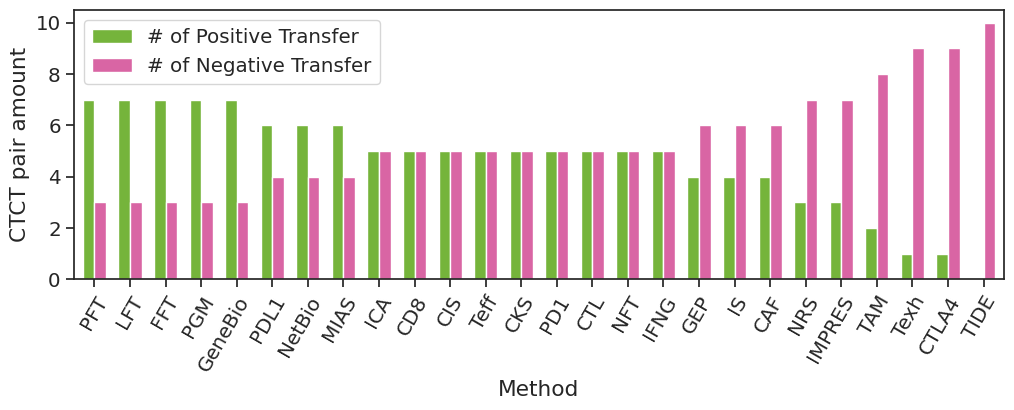

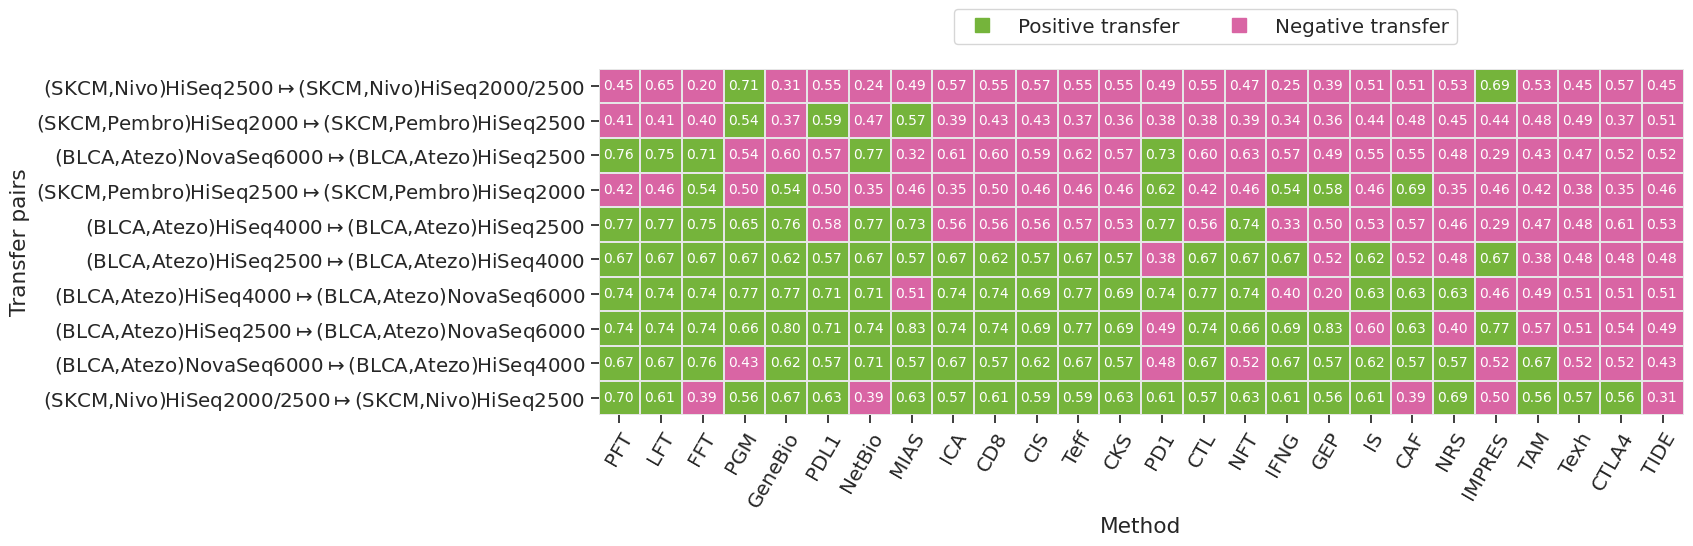

In [428]:
datas = data[data.domain=='sequencer2sequencer']#data[data.train_cohort.isin(sequencer_domain) & data.test_cohort.isin(sequencer_domain)]
data_mt = datas[(datas.ACC > datas.test_cohort_rgc )] # & (datas.MCC > 0)
df_mt = data_mt.groupby('mode').size().to_frame('# of Positive Transfer')

data_nt = datas[(datas.ACC < datas.test_cohort_rgc)] # & (datas.MCC < 0)
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

datas['positive_transfer'] = datas.index.isin(data_mt.index)
datas['negative_transfer'] = datas.index.isin(data_nt.index)

dft = pd.DataFrame([],index=datas['mode'].unique()).join(df_mt).join(df_nt).fillna(0)

fig, ax = plt.subplots(figsize=(12, 3.5),  )

x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
#x_order = (dft[dft.columns[0]]).sort_values(ascending=False).index

dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1, width=0.65)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

fig.savefig('./seqencer2seqencer_bar.pdf', bbox_inches='tight')

# =================================================================================================

dfb1 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'positive_transfer' )
dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

dfb2 = pd.pivot_table(datas, columns = 'mode', index='transfer', values = 'negative_transfer' )
dfb2 = pd.DataFrame(np.where(dfb2 !=0, dfb2, np.nan), index=dfb2.index, columns= dfb2.columns)

#x_order = (dfb1.sum() - dfb2.sum()).sort_values().index
y_order = (dfb1.sum(axis=1) - dfb2.sum(axis=1)).sort_values().index

# x_order = dfb1.sum().sort_values().index
# y_order = dfb1.sum(axis=1).sort_values().index

dfb1 = dfb1[x_order].loc[y_order]
dfb2 = dfb2[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(14, 4.5))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap1 = sns.light_palette(mt_color, n_colors =  2, reverse=True)
cmap2 = sns.light_palette(nt_color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap1, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

sns.heatmap(dfb2, 
        cmap = cmap2, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

x_axis_dict = {}
for i in ax.xaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    x_axis_dict[k] = p
    
y_axis_dict = {}
for i in ax.yaxis.get_ticklabels():
    p = i.get_position()
    k = i.get_text()
    y_axis_dict[k] = p
    
    
for i in range(len(datas)):
    ts = datas.iloc[i]
    v = '%.2f' % ts.ACC
    x = ts['mode']
    y = ts.transfer
    x = x_axis_dict[x][0]-0.4
    y = y_axis_dict[y][1] + 0.1
    
    if ts.positive_transfer | ts.negative_transfer:
        color = 'white'
    else:
        color = 'gray'
    ax.text(x, y, v, fontdict={'fontsize':10, 'color':color})



ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(x_order, 
                    rotation=60, 
                    ha="right",  
                    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('Transfer pairs')
ax.set_xlabel('Method')

l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap1[0], label= 'Positive transfer' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[0], label= 'Negative transfer' )[0]
#l3 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap2[1], label= 'Ambigorious' )[0]

patches = [l1, l2,] # l3
ax.legend(handles=patches, bbox_to_anchor=(0.80,1.2),  
          loc='upper right', ncol=3, facecolor="w", numpoints=1, ) 


fig.savefig('./seqencer2seqencer_heatmap.pdf', bbox_inches='tight')
fig.savefig('./seqencer2seqencer_heatmap.svg', bbox_inches='tight')
dfs_pos = dfb1.sum()/len(dfb1)
dfs_neg = dfb2.sum()/len(dfb2)
x_order_s = x_order

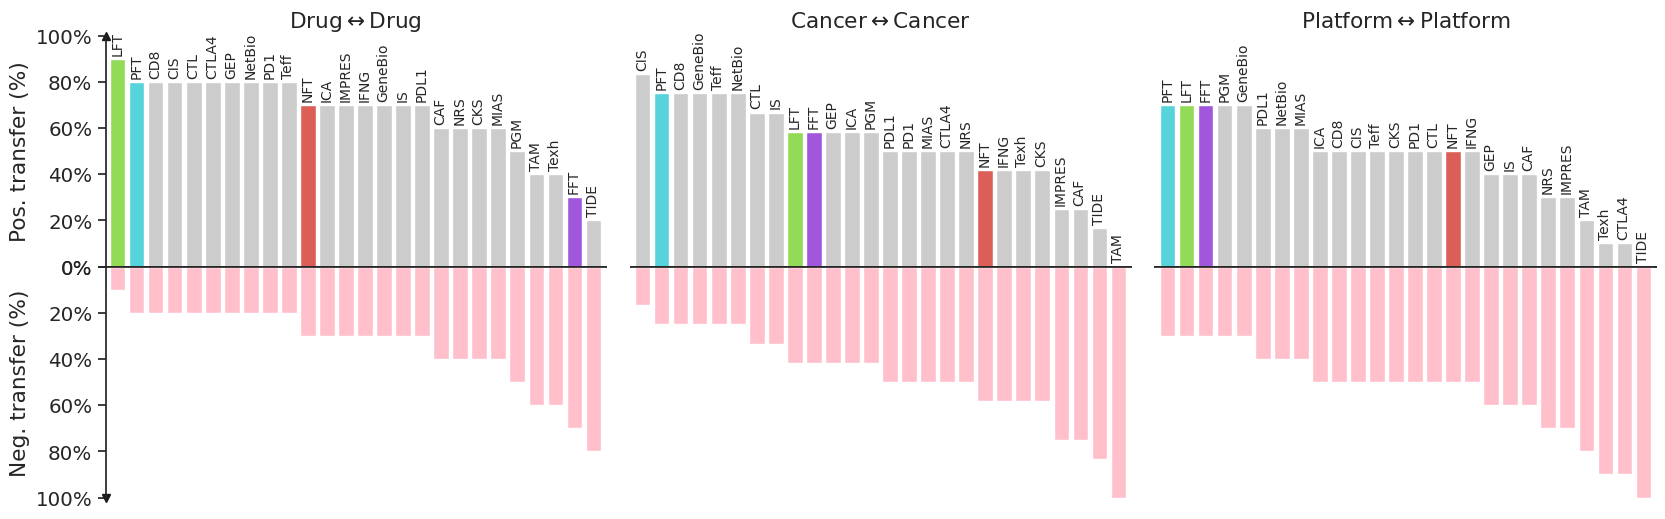

In [429]:
df_pos = pd.concat([dfd_pos,dfc_pos,dfs_pos], axis=1)
df_pos.columns = ['drug2drug', 'cancer2cancer', 'sequencer2sequencer']

df_neg = pd.concat([dfd_neg,dfc_neg,dfs_neg], axis=1)
df_neg.columns = ['drug2drug', 'cancer2cancer', 'sequencer2sequencer']


fig, axes = plt.subplots(  nrows=2, ncols=3, sharey=False, figsize=(20,6))

(ax1, ax2, ax3), (ax4, ax5, ax6) = axes

### drug
sidx = dfd_neg.sort_values(ascending=True).index
dfp = dfd_pos.loc[x_order_d]

color = pd.Series(mode_palette).loc[dfp.index].to_list()
dfp.plot(kind='bar', color = color,ax=ax1, width=0.8)
i = 0
for k, y in dfp.items():
    ax1.text(i-0.4, y + 0.03, k, rotation=90, fontsize=10)
    i += 1

dfd_neg.loc[dfp.index].plot(kind='bar', color = 'pink',ax=ax4, width=0.8)


### cancer

sidx = dfc_neg.sort_values(ascending=True).index
dfp = dfc_pos.loc[x_order_c]
color = pd.Series(mode_palette).loc[dfp.index].to_list()
dfp.plot(kind='bar', color = color,ax=ax2, width=0.8)
i = 0
for k, y in dfp.items():
    ax2.text(i-0.4, y + 0.03, k, rotation=90, fontsize=10)
    i += 1

dfc_neg.loc[dfp.index].plot(kind='bar', color = 'pink',ax=ax5, width=0.8)


### sequencer
sidx = dfs_neg.sort_values(ascending=True).index
dfp = dfs_pos.loc[x_order_s]

color = pd.Series(mode_palette).loc[dfp.index].to_list()
dfp.plot(kind='bar', color = color,ax=ax3, width=0.8)
i = 0
for k, y in dfp.items():
    ax3.text(i-0.4, y + 0.03, k, rotation=90, fontsize=10)
    i += 1

dfs_neg.loc[dfp.index].plot(kind='bar', color = 'pink',ax=ax6, width=0.8)


for i, ax in enumerate( [ax1, ax2, ax3]):
    ax.set_ylim(0.,1)
    ax.set_xticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i != 0:
        ax.spines["left"].set_visible(False)
        ax.get_yaxis().set_ticks([])
    else:
        ax.plot(0, 1, "^k", transform=ax.get_yaxis_transform(), clip_on=False)
        
    ax.set_xlabel('')


for i, ax in enumerate( [ax4, ax5, ax6]):
    ax.set_ylim(0.,1)
    
    ax.set_xticks([])
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.invert_yaxis()
    
    if i != 0:
        ax.spines["left"].set_visible(False)
        ax.get_yaxis().set_ticks([])
    else:
        ax.plot(0, 1, "vk", transform=ax.get_yaxis_transform(), clip_on=False)
    
    ax.set_xlabel('')

ax1.set_ylabel('Pos. transfer (%)')

vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)


ax4.set_ylabel('Neg. transfer (%)')
vals = ax4.get_yticks()
ax4.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
ax4.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)


ax1.set_title('Drug$\leftrightarrow$Drug')
ax2.set_title('Cancer$\leftrightarrow$Cancer')
ax3.set_title('Platform$\leftrightarrow$Platform')


plt.subplots_adjust(wspace=0.05, hspace=0)

fig.savefig('./pos_neg_transfer.pdf', bbox_inches='tight')
fig.savefig('./pos_neg_transfer.svg', bbox_inches='tight')